강아지 이미지 0 저장 완료.
강아지를 찾지 못했습니다: ./pet\dog_1.jpg
강아지를 찾지 못했습니다: ./pet\dog_1.jpg
강아지를 찾지 못했습니다: ./pet\dog_1.jpg
강아지 이미지 1 저장 완료.
강아지 이미지 2 저장 완료.
강아지 이미지 3 저장 완료.
강아지 이미지 4 저장 완료.
강아지를 찾지 못했습니다: ./pet\dog_5.jpg
강아지 이미지 5 저장 완료.
강아지를 찾지 못했습니다: ./pet\dog_6.jpg
강아지 이미지 6 저장 완료.
강아지 이미지 7 저장 완료.
다운로드 실패: Message: element click intercepted: Element  보호 중인 동물 | 강동리본센터" data-iml="1191" data-atf="false"> is not clickable at point (131, 626). Other element would receive the click: <div jsname="r5xl4" class="islrc" role="list" style="width: 551px;">...</div>
  (Session info: chrome=117.0.5938.89)
Stacktrace:
	GetHandleVerifier [0x00007FF7E6A2AFD2+57938]
	(No symbol) [0x00007FF7E6997C02]
	(No symbol) [0x00007FF7E684DAAB]
	(No symbol) [0x00007FF7E689480B]
	(No symbol) [0x00007FF7E6892BD9]
	(No symbol) [0x00007FF7E68909A8]
	(No symbol) [0x00007FF7E688FA63]
	(No symbol) [0x00007FF7E688575F]
	(No symbol) [0x00007FF7E68AEAEA]
	(No symbol) [0x00007FF7E6885076]
	(No symbol) [0x00007FF7E68AED00]
	(No symbo
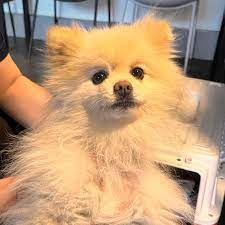

강아지를 찾지 못했습니다: ./pet\dog_8.jpg
강아지를 찾지 못했습니다: ./pet\dog_8.jpg
강아지를 찾지 못했습니다: ./pet\dog_8.jpg
강아지 이미지 8 저장 완료.
강아지 이미지 9 저장 완료.


In [21]:
import os
import time
import urllib.request
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service

# 검색어 설정
search_query = "포메라니안"

# Chrome 웹 드라이버 서비스 객체 생성
chrome_service = Service('C:\\chromedriver\\chromedriver.exe')  # 웹 드라이버 경로 지정

# Chrome 웹 드라이버 설정
driver = webdriver.Chrome(service=chrome_service)

# 구글 이미지 검색 페이지로 이동
driver.get("https://www.google.com/imghp?hl=ko&tab=wi&authuser=0&ogbl")

# 검색어 입력
elem = driver.find_element(By.NAME, "q")
elem.send_keys(search_query)
elem.send_keys(Keys.RETURN)

# 이미지 다운로드 경로 설정
download_path = "./pet"

# 이미지 다운로드 디렉토리 생성
os.makedirs(download_path, exist_ok=True)

# 스크롤해서 더 많은 이미지 로드
SCROLL_PAUSE_TIME = 0.1
last_height = driver.execute_script("return document.body.scrollHeight")
while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(SCROLL_PAUSE_TIME)
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        try:
            driver.find_element(By.CSS_SELECTOR, ".mye4qd").click()
        except:
            break
    last_height = new_height

# 원하는 저장 개수 설정
desired_save_count = 10
saved_count = 0

# 이미지 다운로드 및 강아지 영역 크롭 및 저장
image_elements = driver.find_elements(By.CSS_SELECTOR, ".rg_i.Q4LuWd")

for image_element in image_elements:
    try:
        # 이미지 클릭 및 로드 대기
        image_element.click()
        time.sleep(2)
        
        # TensorFlow Hub에서 SSD 모델 로드
        model_url = 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2'
        model = hub.load(model_url)
        
        # 이미지 다운로드 경로 설정
        image_path = os.path.join(download_path, f"dog_{saved_count}.jpg")
        
        # 이미지 다운로드
        urllib.request.urlretrieve(image_element.get_attribute('src'), image_path)
        
        # 이미지 크롭
        img = cv2.imread(image_path)
        
        # 모델에 이미지 전달
        input_tensor = tf.convert_to_tensor(img)
        results = model(input_tensor[tf.newaxis, ...])
        
        # 감지 결과 추출
        num_detections = int(results.pop('num_detections'))
        class_ids = results['detection_classes'][0].numpy().astype(int)
        scores = results['detection_scores'][0].numpy()
        boxes = results['detection_boxes'][0].numpy()
        
        # 강아지(클래스 ID: 18)만 추출
        dog_indices = [i for i, class_id in enumerate(class_ids) if class_id == 18 and scores[i] > 0.5]
        
        # 강아지가 감지된 경우에만 처리
        if dog_indices:
            for i in dog_indices:
                y1, x1, y2, x2 = boxes[i]
                h, w, _ = img.shape
                x1, y1, x2, y2 = int(x1 * w), int(y1 * h), int(x2 * w), int(y2 * h)
                
                # 강아지 영역 크롭 및 저장
                dog_image = img[y1:y2, x1:x2]
                
                # 크롭된 강아지 이미지 저장 (파일 이름에 saved_count 사용)
                cv2.imwrite(image_path, dog_image)  # 이미지 파일 저장
                print(f"강아지 이미지 {saved_count} 저장 완료.")
                
                saved_count += 1  # 저장된 이미지 개수 증가
                
                # 원하는 개수만큼 이미지를 저장한 경우 종료
                if saved_count >= desired_save_count:
                    break
        else:
            print(f"강아지를 찾지 못했습니다: {image_path}")
            # 이미지 저장에 실패한 경우 파일 삭제
            os.remove(image_path)
        
        # 원하는 개수만큼 이미지를 저장한 경우 종료
        if saved_count >= desired_save_count:
            break
    except Exception as e:
        print(f"다운로드 실패: {str(e)}")

# 브라우저 종료
driver.quit()

강아지 얼굴 이미지 1 저장 완료.
강아지 얼굴 이미지 2 저장 완료.
강아지 얼굴 이미지 3 저장 완료.
강아지 얼굴 이미지 4 저장 완료.
강아지 얼굴 이미지 4 저장 완료.
강아지 얼굴 이미지 4 저장 완료.
강아지 얼굴 이미지 4 저장 완료.
강아지 얼굴 이미지 4 저장 완료.
강아지 얼굴 이미지 4 저장 완료.
강아지 얼굴 이미지 5 저장 완료.
강아지 얼굴 이미지 6 저장 완료.
다운로드 실패: Message: element click intercepted: Element  is not clickable at point (94, 636). Other element would receive the click: <div jsname="r5xl4" class="islrc" role="list" style="width: 551px;">...</div>
  (Session info: chrome=117.0.5938.89)
Stacktrace:
	GetHandleVerifier [0x00007FF6DCFBAFD2+57938]
	(No symbol) [0x00007FF6DCF27C02]
	(No symbol) [0x00007FF6DCDDDAAB]
	(No symbol) [0x00007FF6DCE2480B]
	(No symbol) [0x00007FF6DCE22BD9]
	(No symbol) [0x00007FF6DCE209A8]
	(No symbol) [0x00007FF6DCE1FA63]
	(No symbol) [0x00007FF6DCE1575F]
	(No symbol) [0x00007FF6DCE3EAEA]
	(No symbol) [0x00007FF6DCE15076]
	(No symbol) [0x00007FF6DCE3ED00]
	(No symbol) [0x00007FF6DCE57852]
	(No symbol) [0x00007FF6DCE3E8C3]
	(No symbol) [0x00007FF6DCE136D1]
	(No symbol) [0x00007FF6DCE14914]
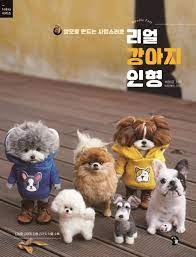

강아지 얼굴 이미지 7 저장 완료.
강아지 얼굴 이미지 8 저장 완료.
강아지 얼굴 이미지 9 저장 완료.
강아지 얼굴 이미지 9 저장 완료.
강아지 얼굴 이미지 10 저장 완료.


In [11]:
import os
import time
import urllib.request
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
import json

# 검색어 설정
search_query = "사랑스러운 강아지"

# Chrome 웹 드라이버 서비스 객체 생성
chrome_service = Service('C:\\chromedriver\\chromedriver.exe')  # 웹 드라이버 경로 지정

# Chrome 웹 드라이버 설정
driver = webdriver.Chrome(service=chrome_service)

# 구글 이미지 검색 페이지로 이동
driver.get("https://www.google.com/imghp?hl=ko&tab=wi&authuser=0&ogbl")

# 검색어 입력
elem = driver.find_element(By.NAME, "q")
elem.send_keys(search_query)
elem.send_keys(Keys.RETURN)

# 이미지 다운로드 경로 설정
download_path = "./pet"

# 이미지 다운로드 디렉토리 생성
os.makedirs(download_path, exist_ok=True)

# 스크롤해서 더 많은 이미지 로드
SCROLL_PAUSE_TIME = 0.1
last_height = driver.execute_script("return document.body.scrollHeight")
while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(SCROLL_PAUSE_TIME)
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        try:
            driver.find_element(By.CSS_SELECTOR, ".mye4qd").click()
        except:
            break
    last_height = new_height

# 원하는 저장 개수 설정
desired_save_count = 10
saved_count = 0  # 저장된 이미지 개수 초기화

# 바운딩 박스 정보를 저장할 리스트 생성
bounding_boxes = []

# 이미지 다운로드 및 강아지 얼굴 영역 크롭 및 저장
image_elements = driver.find_elements(By.CSS_SELECTOR, ".rg_i.Q4LuWd")

# TensorFlow Hub에서 SSD 모델 로드
model_url = 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2'
model = hub.load(model_url)

for image_element in image_elements:
    try:
        # 이미지 클릭 및 로드 대기
        image_element.click()
        time.sleep(2)

        # 이미지 다운로드 경로 설정
        image_path = os.path.join(download_path, f"dog_{saved_count + 1}.jpg")

        # 이미지 다운로드
        urllib.request.urlretrieve(image_element.get_attribute('src'), image_path)

        # 이미지 크롭
        img = cv2.imread(image_path)

        # 모델에 이미지 전달
        input_tensor = tf.convert_to_tensor(img)
        results = model(input_tensor[tf.newaxis, ...])

        # 감지 결과 추출
        num_detections = int(results.pop('num_detections'))
        class_ids = results['detection_classes'][0].numpy().astype(int)
        scores = results['detection_scores'][0].numpy()
        boxes = results['detection_boxes'][0].numpy()

        # 강아지(클래스 ID: 18)만 추출
        dog_indices = [i for i, class_id in enumerate(class_ids) if class_id == 18 and scores[i] > 0.5]

        # 강아지가 감지된 경우에만 처리
        if dog_indices:
            saved_count += 1  # 저장된 이미지 개수 증가

            for i in dog_indices:
                if saved_count > desired_save_count:
                    break  # 이미 원하는 개수만큼 이미지를 저장한 경우 종료

                y1, x1, y2, x2 = boxes[i]
                h, w, _ = img.shape
                x1, y1, x2, y2 = int(x1 * w), int(y1 * h), int(x2 * w), int(y2 * h)

                # 바운딩 박스 정보 추가
                bounding_box = {
                    "x1": x1,
                    "y1": y1,
                    "x2": x2,
                    "y2": y2
                }
                bounding_boxes.append(bounding_box)

                # 강아지 얼굴 영역에 바운딩 박스 그리기 (빨간색, 두께 2)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # 크롭된 강아지 얼굴 이미지 저장 (파일 이름에 saved_count 사용)
                cv2.imwrite(image_path, img)  # 이미지 파일 저장
                print(f"강아지 얼굴 이미지 {saved_count} 저장 완료.")

    except Exception as e:
        print(f"다운로드 실패: {str(e)}")

    # 이미지 저장 개수가 원하는 개수와 같거나 더 많다면 종료
    if saved_count >= desired_save_count:
        break

# 바운딩 박스 정보를 JSON 파일로 저장
with open('./pet/json/bounding_boxes.json', 'w') as json_file:
    json.dump(bounding_boxes, json_file)

# 브라우저 종료
driver.quit()

강아지 얼굴 이미지 1 저장 완료.
강아지 얼굴 이미지 2 저장 완료.
강아지 얼굴 이미지 3 저장 완료.
강아지 얼굴 이미지 4 저장 완료.
강아지 얼굴 이미지 4 저장 완료.
강아지 얼굴 이미지 4 저장 완료.
강아지 얼굴 이미지 4 저장 완료.
강아지 얼굴 이미지 4 저장 완료.
강아지 얼굴 이미지 4 저장 완료.
다운로드 실패: Message: element click intercepted: Element  is not clickable at point (165, 636). Other element would receive the click: <div jsname="r5xl4" class="islrc" role="list" style="width: 551px;">...</div>
  (Session info: chrome=117.0.5938.92)
Stacktrace:
	GetHandleVerifier [0x00007FF6CC6CAFD2+57938]
	(No symbol) [0x00007FF6CC637C02]
	(No symbol) [0x00007FF6CC4EDAAB]
	(No symbol) [0x00007FF6CC53480B]
	(No symbol) [0x00007FF6CC532BD9]
	(No symbol) [0x00007FF6CC5309A8]
	(No symbol) [0x00007FF6CC52FA63]
	(No symbol) [0x00007FF6CC52575F]
	(No symbol) [0x00007FF6CC54EAEA]
	(No symbol) [0x00007FF6CC525076]
	(No symbol) [0x00007FF6CC54ED00]
	(No symbol) [0x00007FF6CC567852]
	(No symbol) [0x00007FF6CC54E8C3]
	(No symbol) [0x00007FF6CC5236D1]
	(No symbol) [0x00007FF6CC524914]
	GetHandleVerifier [0x00007FF6CCA2E772
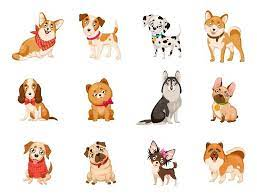

다운로드 실패: Message: element click intercepted: Element  is not clickable at point (117, 634). Other element would receive the click: <div jsname="r5xl4" class="islrc" role="list" style="width: 551px;">...</div>
  (Session info: chrome=117.0.5938.92)
Stacktrace:
	GetHandleVerifier [0x00007FF6CC6CAFD2+57938]
	(No symbol) [0x00007FF6CC637C02]
	(No symbol) [0x00007FF6CC4EDAAB]
	(No symbol) [0x00007FF6CC53480B]
	(No symbol) [0x00007FF6CC532BD9]
	(No symbol) [0x00007FF6CC5309A8]
	(No symbol) [0x00007FF6CC52FA63]
	(No symbol) [0x00007FF6CC52575F]
	(No symbol) [0x00007FF6CC54EAEA]
	(No symbol) [0x00007FF6CC525076]
	(No symbol) [0x00007FF6CC54ED00]
	(No symbol) [0x00007FF6CC567852]
	(No symbol) [0x00007FF6CC54E8C3]
	(No symbol) [0x00007FF6CC5236D1]
	(No symbol) [0x00007FF6CC524914]
	GetHandleVerifier [0x00007FF6CCA2E772+3611122]
	GetHandleVerifier [0x00007FF6CCA81640+3950784]
	GetHandleVerifier [0x00007FF6CCA7A6EF+3922287]
	GetHandleVerifier [0x00007FF6CC768996+703510]
	(No symbol) [0x00007FF6CC6
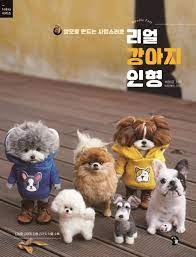

강아지 얼굴 이미지 5 저장 완료.
다운로드 실패: Message: element click intercepted: Element  is not clickable at point (147, 622). Other element would receive the click: <div jsname="r5xl4" class="islrc" role="list" style="width: 551px;">...</div>
  (Session info: chrome=117.0.5938.92)
Stacktrace:
	GetHandleVerifier [0x00007FF6CC6CAFD2+57938]
	(No symbol) [0x00007FF6CC637C02]
	(No symbol) [0x00007FF6CC4EDAAB]
	(No symbol) [0x00007FF6CC53480B]
	(No symbol) [0x00007FF6CC532BD9]
	(No symbol) [0x00007FF6CC5309A8]
	(No symbol) [0x00007FF6CC52FA63]
	(No symbol) [0x00007FF6CC52575F]
	(No symbol) [0x00007FF6CC54EAEA]
	(No symbol) [0x00007FF6CC525076]
	(No symbol) [0x00007FF6CC54ED00]
	(No symbol) [0x00007FF6CC567852]
	(No symbol) [0x00007FF6CC54E8C3]
	(No symbol) [0x00007FF6CC5236D1]
	(No symbol) [0x00007FF6CC524914]
	GetHandleVerifier [0x00007FF6CCA2E772+3611122]
	GetHandleVerifier [0x00007FF6CCA81640+3950784]
	GetHandleVerifier [0x00007FF6CCA7A6EF+3922287]
	GetHandleVerifier [0x00007FF6CC768996+703510]
	(No sy
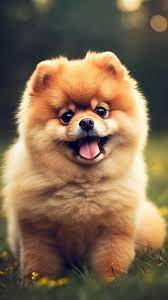

강아지 얼굴 이미지 6 저장 완료.
강아지 얼굴 이미지 7 저장 완료.
다운로드 실패: Message: element click intercepted: Element  is not clickable at point (164, 636). Other element would receive the click: <div jsname="r5xl4" class="islrc" role="list" style="width: 551px;">...</div>
  (Session info: chrome=117.0.5938.92)
Stacktrace:
	GetHandleVerifier [0x00007FF6CC6CAFD2+57938]
	(No symbol) [0x00007FF6CC637C02]
	(No symbol) [0x00007FF6CC4EDAAB]
	(No symbol) [0x00007FF6CC53480B]
	(No symbol) [0x00007FF6CC532BD9]
	(No symbol) [0x00007FF6CC5309A8]
	(No symbol) [0x00007FF6CC52FA63]
	(No symbol) [0x00007FF6CC52575F]
	(No symbol) [0x00007FF6CC54EAEA]
	(No symbol) [0x00007FF6CC525076]
	(No symbol) [0x00007FF6CC54ED00]
	(No symbol) [0x00007FF6CC567852]
	(No symbol) [0x00007FF6CC54E8C3]
	(No symbol) [0x00007FF6CC5236D1]
	(No symbol) [0x00007FF6CC524914]
	GetHandleVerifier [0x00007FF6CCA2E772+3611122]
	GetHandleVerifier [0x00007FF6CCA81640+3950784]
	GetHandleVerifier [0x00007FF6CCA7A6EF+3922287]
	GetHandleVerifier [0x00007FF6CC76
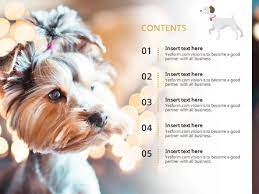

다운로드 실패: Message: element click intercepted: Element  is not clickable at point (440, 636). Other element would receive the click: <div jsname="r5xl4" class="islrc" role="list" style="width: 551px;">...</div>
  (Session info: chrome=117.0.5938.92)
Stacktrace:
	GetHandleVerifier [0x00007FF6CC6CAFD2+57938]
	(No symbol) [0x00007FF6CC637C02]
	(No symbol) [0x00007FF6CC4EDAAB]
	(No symbol) [0x00007FF6CC53480B]
	(No symbol) [0x00007FF6CC532BD9]
	(No symbol) [0x00007FF6CC5309A8]
	(No symbol) [0x00007FF6CC52FA63]
	(No symbol) [0x00007FF6CC52575F]
	(No symbol) [0x00007FF6CC54EAEA]
	(No symbol) [0x00007FF6CC525076]
	(No symbol) [0x00007FF6CC54ED00]
	(No symbol) [0x00007FF6CC567852]
	(No symbol) [0x00007FF6CC54E8C3]
	(No symbol) [0x00007FF6CC5236D1]
	(No symbol) [0x00007FF6CC524914]
	GetHandleVerifier [0x00007FF6CCA2E772+3611122]
	GetHandleVerifier [0x00007FF6CCA81640+3950784]
	GetHandleVerifier [0x00007FF6CCA7A6EF+3922287]
	GetHandleVerifier [0x00007FF6CC768996+703510]
	(No symbol) [0x00007FF6CC6
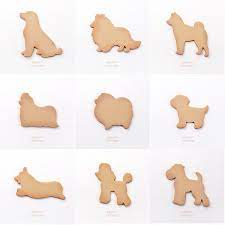

In [1]:
import os
import time
import urllib.request
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
import json

# 검색어 설정
search_query = "사랑스러운 강아지"

# Chrome 웹 드라이버 서비스 객체 생성
chrome_service = Service('C:\\chromedriver\\chromedriver.exe')  # 웹 드라이버 경로 지정

# Chrome 웹 드라이버 설정
driver = webdriver.Chrome(service=chrome_service)

# 구글 이미지 검색 페이지로 이동
driver.get("https://www.google.com/imghp?hl=ko&tab=wi&authuser=0&ogbl")

# 검색어 입력
elem = driver.find_element(By.NAME, "q")
elem.send_keys(search_query)
elem.send_keys(Keys.RETURN)

# 이미지 다운로드 경로 설정
download_path = "./pet"

# 이미지 다운로드 디렉토리 생성
os.makedirs(download_path, exist_ok=True)

# 스크롤해서 더 많은 이미지 로드
SCROLL_PAUSE_TIME = 0.1
last_height = driver.execute_script("return document.body.scrollHeight")
while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(SCROLL_PAUSE_TIME)
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        try:
            driver.find_element(By.CSS_SELECTOR, ".mye4qd").click()
        except:
            break
    last_height = new_height

# 원하는 저장 개수 설정
desired_save_count = 10
saved_count = 0  # 저장된 이미지 개수 초기화

# 바운딩 박스 정보를 저장할 리스트 생성
bounding_boxes = []

# 이미지 다운로드 및 강아지 얼굴 영역 크롭 및 저장
image_elements = driver.find_elements(By.CSS_SELECTOR, ".rg_i.Q4LuWd")

# TensorFlow Hub에서 SSD 모델 로드
model_url = 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2'
model = hub.load(model_url)

# 이미지 크기 설정
desired_image_size = (1024, 1024)

for image_element in image_elements:
    try:
        # 이미지 클릭 및 로드 대기
        image_element.click()
        time.sleep(2)

        # 이미지 다운로드 경로 설정
        image_path = os.path.join(download_path, f"dog_{saved_count + 1}.jpg")

        # 이미지 다운로드
        urllib.request.urlretrieve(image_element.get_attribute('src'), image_path)

        # 이미지 크기를 128, 128으로 조정
        img = cv2.imread(image_path)
        img = cv2.resize(img, desired_image_size)  # 이미지 크기 조정

        # 모델에 이미지 전달
        input_tensor = tf.convert_to_tensor(img)
        results = model(input_tensor[tf.newaxis, ...])

        # 감지 결과 추출
        num_detections = int(results.pop('num_detections'))
        class_ids = results['detection_classes'][0].numpy().astype(int)
        scores = results['detection_scores'][0].numpy()
        boxes = results['detection_boxes'][0].numpy()

        # 강아지(클래스 ID: 18)만 추출
        dog_indices = [i for i, class_id in enumerate(class_ids) if class_id == 18 and scores[i] > 0.5]

        # 강아지가 감지된 경우에만 처리
        if dog_indices:
            saved_count += 1  # 저장된 이미지 개수 증가

            for i in dog_indices:
                if saved_count > desired_save_count:
                    break  # 이미지를 원하는 개수만큼 저장한 경우 종료

                y1, x1, y2, x2 = boxes[i]
                h, w, _ = img.shape
                x1, y1, x2, y2 = int(x1 * w), int(y1 * h), int(x2 * w), int(y2 * h)

                # 바운딩 박스 정보 추가
                bounding_box = {
                    "x1": x1,
                    "y1": y1,
                    "x2": x2,
                    "y2": y2
                }
                bounding_boxes.append(bounding_box)

                # 강아지 얼굴 영역에 바운딩 박스 그리기 (초록색, 두께 2)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # 이미지를 고화질로 저장 (품질 100)
                cv2.imwrite(image_path, img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

                print(f"강아지 얼굴 이미지 {saved_count} 저장 완료.")

    except Exception as e:
        print(f"다운로드 실패: {str(e)}")

    # 이미지 저장 개수가 원하는 개수와 같거나 더 많다면 종료
    if saved_count >= desired_save_count:
        break

# 바운딩 박스 정보를 JSON 파일로 저장
with open('./pet/json/bounding_boxes.json', 'w') as json_file:
    json.dump(bounding_boxes, json_file)

# 브라우저 종료
driver.quit()

In [1]:
import os
import cv2

# 이미지가 저장된 폴더 경로
image_dir = "./dog_to_human/dog"

# 이미지 파일 목록 가져오기
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

# 이미지 크기를 64x64로 변환하고 덮어쓰기
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)

    # 이미지 로드
    img = cv2.imread(image_path)

    # 이미지 크기를 64x64로 조정
    img_64x64 = cv2.resize(img, (64, 64))

    # 64x64 이미지를 원본 이미지로 덮어쓰기
    cv2.imwrite(image_path, img_64x64)

    print(f"{image_file} 이미지를 16x16 크기로 덮어썼습니다.")

print("일괄 덮어쓰기 완료.")

dog_1.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_10.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_11.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_12.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_13.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_14.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_15.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_16.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_17.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_18.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_19.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_2.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_20.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_21.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_22.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_23.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_24.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_25.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_26.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_27.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_28.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_29.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_3.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_30.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_31.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_32.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_33.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_34.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_35.jpg 이미지를 16x16 크기로 덮어썼습니다.
dog_36.jpg 이미지를 1

강아지 얼굴 이미지 1 저장 완료.
강아지 얼굴 이미지 2 저장 완료.
강아지 얼굴 이미지 3 저장 완료.
강아지 얼굴 이미지 4 저장 완료.
강아지 얼굴 이미지 5 저장 완료.
강아지 얼굴 이미지 6 저장 완료.
다운로드 실패: Message: element click intercepted: Element  is not clickable at point (129, 635). Other element would receive the click: <div jsname="r5xl4" class="islrc" role="list" style="width: 551px;">...</div>
  (Session info: chrome=117.0.5938.92)
Stacktrace:
	GetHandleVerifier [0x00007FF687B5AFD2+57938]
	(No symbol) [0x00007FF687AC7C02]
	(No symbol) [0x00007FF68797DAAB]
	(No symbol) [0x00007FF6879C480B]
	(No symbol) [0x00007FF6879C2BD9]
	(No symbol) [0x00007FF6879C09A8]
	(No symbol) [0x00007FF6879BFA63]
	(No symbol) [0x00007FF6879B575F]
	(No symbol) [0x00007FF6879DEAEA]
	(No symbol) [0x00007FF6879B5076]
	(No symbol) [0x00007FF6879DED00]
	(No symbol) [0x00007FF6879F7852]
	(No symbol) [0x00007FF6879DE8C3]
	(No symbol) [0x00007FF6879B36D1]
	(No symbol) [0x00007FF6879B4914]
	GetHandleVerifier [0x00007FF687EBE772+3611122]
	GetHandleVerifier [0x00007FF687F11640+3950784]
	G
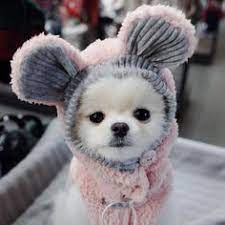

강아지 얼굴 이미지 7 저장 완료.
강아지 얼굴 이미지 8 저장 완료.
강아지 얼굴 이미지 9 저장 완료.
강아지 얼굴 이미지 9 저장 완료.
다운로드 실패: Message: element click intercepted: Element  is not clickable at point (151, 636). Other element would receive the click: <div jsname="r5xl4" class="islrc" role="list" style="width: 551px;">...</div>
  (Session info: chrome=117.0.5938.92)
Stacktrace:
	GetHandleVerifier [0x00007FF687B5AFD2+57938]
	(No symbol) [0x00007FF687AC7C02]
	(No symbol) [0x00007FF68797DAAB]
	(No symbol) [0x00007FF6879C480B]
	(No symbol) [0x00007FF6879C2BD9]
	(No symbol) [0x00007FF6879C09A8]
	(No symbol) [0x00007FF6879BFA63]
	(No symbol) [0x00007FF6879B575F]
	(No symbol) [0x00007FF6879DEAEA]
	(No symbol) [0x00007FF6879B5076]
	(No symbol) [0x00007FF6879DED00]
	(No symbol) [0x00007FF6879F7852]
	(No symbol) [0x00007FF6879DE8C3]
	(No symbol) [0x00007FF6879B36D1]
	(No symbol) [0x00007FF6879B4914]
	GetHandleVerifier [0x00007FF687EBE772+3611122]
	GetHandleVerifier [0x00007FF687F11640+3950784]
	GetHandleVerifier [0x00007FF687F0A6EF+392
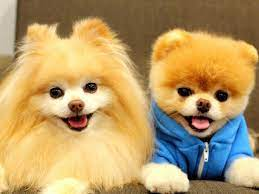

강아지 얼굴 이미지 10 저장 완료.
강아지 얼굴 이미지 11 저장 완료.
강아지 얼굴 이미지 12 저장 완료.
강아지 얼굴 이미지 13 저장 완료.
강아지 얼굴 이미지 13 저장 완료.
강아지 얼굴 이미지 14 저장 완료.
강아지 얼굴 이미지 15 저장 완료.
강아지 얼굴 이미지 16 저장 완료.
강아지 얼굴 이미지 17 저장 완료.
강아지 얼굴 이미지 17 저장 완료.
강아지 얼굴 이미지 17 저장 완료.
강아지 얼굴 이미지 17 저장 완료.
강아지 얼굴 이미지 18 저장 완료.
강아지 얼굴 이미지 19 저장 완료.
강아지 얼굴 이미지 19 저장 완료.
강아지 얼굴 이미지 19 저장 완료.
강아지 얼굴 이미지 20 저장 완료.
강아지 얼굴 이미지 21 저장 완료.
다운로드 실패: Message: element click intercepted: Element <img data-ils="4" jsaction="rcuQ6b:trigger.M8vzZb;" class="rg_i Q4LuWd" jsname="Q4LuWd" width="259" height="195" alt="귀여운 강아지 보구가세요 - 자유게시판 - 땡글닷컴" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSIaaNBOszJkvRaqVfWTNAbQBJx2QGmm7dLgw&amp;usqp=CAU"> is not clickable at point (176, 633). Other element would receive the click: <div jsname="r5xl4" class="islrc" role="list" style="width: 551px;">...</div>
  (Session info: chrome=117.0.5938.92)
Stacktrace:
	GetHandleVerifier [0x00007FF687B5AFD2+57938]
	(No symbol) [0x00007FF687AC7C02]
	(No symbol) [0x00007FF6

강아지 얼굴 이미지 66 저장 완료.
강아지 얼굴 이미지 67 저장 완료.
강아지 얼굴 이미지 68 저장 완료.
강아지 얼굴 이미지 68 저장 완료.
강아지 얼굴 이미지 69 저장 완료.
강아지 얼굴 이미지 70 저장 완료.
강아지 얼굴 이미지 70 저장 완료.
다운로드 실패: Message: element click intercepted: Element <img data-ils="4" jsaction="rcuQ6b:trigger.M8vzZb;" class="rg_i Q4LuWd" jsname="Q4LuWd" width="170" height="200" alt="아 비 (dhejxhsi) - Profile | Pinterest" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT6VIwhuOBlC8Vkop6ABpM1lEn-2nfIo-154g&amp;usqp=CAU"> is not clickable at point (119, 634). Other element would receive the click: <div jsname="r5xl4" class="islrc" role="list" style="width: 551px;">...</div>
  (Session info: chrome=117.0.5938.92)
Stacktrace:
	GetHandleVerifier [0x00007FF687B5AFD2+57938]
	(No symbol) [0x00007FF687AC7C02]
	(No symbol) [0x00007FF68797DAAB]
	(No symbol) [0x00007FF6879C480B]
	(No symbol) [0x00007FF6879C2BD9]
	(No symbol) [0x00007FF6879C09A8]
	(No symbol) [0x00007FF6879BFA63]
	(No symbol) [0x00007FF6879B575F]
	(No symbol) [0x00007FF6879DEAEA]
	(No symb

In [1]:
import os
import time
import urllib.request
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
import json

# 검색어 설정
search_query = "고화질 귀여운 강아지"

# Chrome 웹 드라이버 서비스 객체 생성
chrome_service = Service('C:\\chromedriver\\chromedriver.exe')  # 웹 드라이버 경로 지정

# Chrome 웹 드라이버 설정
driver = webdriver.Chrome(service=chrome_service)

# 구글 이미지 검색 페이지로 이동
driver.get("https://www.google.com/imghp?hl=ko&tab=wi&authuser=0&ogbl")

# 검색어 입력
elem = driver.find_element(By.NAME, "q")
elem.send_keys(search_query)
elem.send_keys(Keys.RETURN)

# 이미지 다운로드 경로 설정
download_path = "./pet"

# 이미지 다운로드 디렉토리 생성
os.makedirs(download_path, exist_ok=True)

# 스크롤해서 더 많은 이미지 로드
SCROLL_PAUSE_TIME = 0.1
last_height = driver.execute_script("return document.body.scrollHeight")
while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(SCROLL_PAUSE_TIME)
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        try:
            driver.find_element(By.CSS_SELECTOR, ".mye4qd").click()
        except:
            break
    last_height = new_height

# 원하는 저장 개수 설정
desired_save_count = 150
saved_count = 0  # 저장된 이미지 개수 초기화

# 바운딩 박스 정보를 저장할 리스트 생성
bounding_boxes = []

# 이미지 다운로드 및 강아지 얼굴 영역 크롭 및 저장
image_elements = driver.find_elements(By.CSS_SELECTOR, ".rg_i.Q4LuWd")

# TensorFlow Hub에서 SSD 모델 로드
model_url = 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2'
model = hub.load(model_url)

# 이미지 크기 설정
desired_image_size = (256, 256)

for image_element in image_elements:
    try:
        # 이미지 클릭 및 로드 대기
        image_element.click()
        time.sleep(2)

        # 이미지 다운로드 경로 설정
        image_path = os.path.join(download_path, f"dog_{saved_count + 1}.jpg")

        # 이미지 다운로드
        urllib.request.urlretrieve(image_element.get_attribute('src'), image_path)

        # 이미지 크기를 128, 128으로 조정
        img = cv2.imread(image_path)
        img = cv2.resize(img, desired_image_size)  # 이미지 크기 조정

        # 모델에 이미지 전달
        input_tensor = tf.convert_to_tensor(img)
        results = model(input_tensor[tf.newaxis, ...])

        # 감지 결과 추출
        num_detections = int(results.pop('num_detections'))
        class_ids = results['detection_classes'][0].numpy().astype(int)
        scores = results['detection_scores'][0].numpy()
        boxes = results['detection_boxes'][0].numpy()

        # 강아지(클래스 ID: 18)만 추출
        dog_indices = [i for i, class_id in enumerate(class_ids) if class_id == 18 and scores[i] > 0.5]

        # 강아지가 감지된 경우에만 처리
        if dog_indices:
            saved_count += 1  # 저장된 이미지 개수 증가

            for i in dog_indices:
                if saved_count > desired_save_count:
                    break  # 이미지를 원하는 개수만큼 저장한 경우 종료

                y1, x1, y2, x2 = boxes[i]
                h, w, _ = img.shape
                x1, y1, x2, y2 = int(x1 * w), int(y1 * h), int(x2 * w), int(y2 * h)

                # 강아지 얼굴 영역 자르고 저장
                margin = 0
                face_cropped = img[max(0, y1 - margin):min(y2 + margin, img.shape[0]),
                                   max(0, x1 - margin):min(x2 + margin, img.shape[1])]

                # 이미지를 고화질로 저장 (품질 100)
                cv2.imwrite(image_path, face_cropped, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

                print(f"강아지 얼굴 이미지 {saved_count} 저장 완료.")

                # 바운딩 박스 정보 추가
                bounding_box = {
                    "x1": x1,
                    "y1": y1,
                    "x2": x2,
                    "y2": y2
                }
                bounding_boxes.append(bounding_box)

    except Exception as e:
        print(f"다운로드 실패: {str(e)}")

    # 이미지 저장 개수가 원하는 개수와 같거나 더 많다면 종료
    if saved_count >= desired_save_count:
        break

# 바운딩 박스 정보를 JSON 파일로 저장
with open('./pet/json/bounding_boxes.json', 'w') as json_file:
    json.dump(bounding_boxes, json_file)

# 브라우저 종료
driver.quit()